# Distinguishing Reality: Classifying Real vs. AI-Generated Images
In this notebook, we will explore the task of classifying images as real or AI-generated using fine-tuning techniques with several well-known CNN architectures. For this classification task, we will use the CIFAKE dataset, which includes both real and AI-generated images.

Link for the dataset: [CIFAKE: Real and AI-Generated Synthetic Images](https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images)

### Load Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image, ImageChops, ImageEnhance
from tqdm import tqdm
from pathlib import Path
import pandas as pd
import os
from collections import Counter
import torch 
from torchvision import datasets, transforms
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import torch.optim
from glob import glob 
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, Subset
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
import itertools

In [ ]:
from utils.data_utils import *
from utils.visualize_utils import *
from utils.training_utils import *
from utils.ela_utils import *

plt.style.use("ggplot")

### Device Configuration

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set device to GPU if available
print("Device:", device)  # Print device

if device.type == "cuda":  # If GPU is available
    print(torch.cuda.get_device_name(0))  # Print the GPU name
    print("Memory Allocated:", torch.cuda.memory_allocated(0) / 1024 ** 2, "MB")  # Print the allocated memory
    print("Memory Cached:", torch.cuda.memory_reserved(0) / 1024 ** 2, "MB")  # Print the cached memory

Device: cpu


In [4]:
# If using multiple GPUs
device = torch.device("cuda:1")
print("Device:", device)  # Print device

Device: cuda:1


In [32]:
# clear GPU memory
torch.cuda.empty_cache()

### Data preparation: Original

In [4]:
from image_dataset import Image_Dataset

img_height = 224
img_width = 224

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
# train_set = glob("./dataset/train/*/*")
train_dataset = Image_Dataset("./dataset/train/", transform=transform)

# test_set = glob("./dataset/test/*/*")
test_dataset = Image_Dataset("./dataset/test/", transform=transform)

print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

train_ds, valid_ds = train_dataset.split_dataset(train_size=0.8)

Train dataset size: 100000
Test dataset size: 20000


In [5]:
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader = DataLoader(valid_ds, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Original length of the dataset
print("Original length of the training dataset:", len(train_ds))
print("Original length of the validation dataset:", len(valid_ds))
print("Original length of the test dataset:", len(test_dataset))
# Length of the dataloaders
print("Length of the training dataloader:", len(train_loader))
print("Length of the validation dataloader:", len(val_loader))
print("Length of the test dataloader:", len(test_loader))

Original length of the training dataset: 80000
Original length of the validation dataset: 20000
Original length of the test dataset: 20000
Length of the training dataloader: 625
Length of the validation dataloader: 157
Length of the test dataloader: 157


In [6]:
# count_classes(train_loader)
# count_classes(val_loader)
# count_classes(test_loader)

Feature batch shape: torch.Size([128, 3, 224, 224])
Labels batch shape: torch.Size([128])


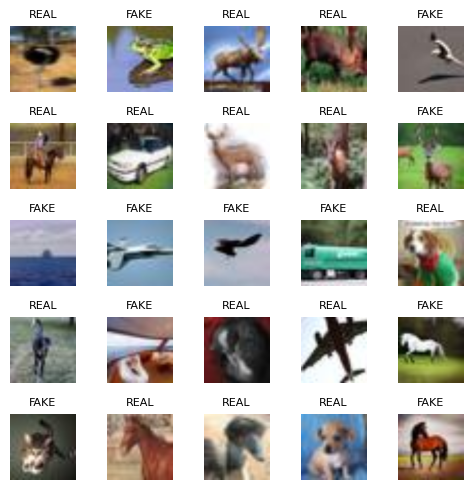

In [7]:
# display 5*5 images
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
# display 5*5 images

plot_images(train_features, train_labels)

### Data preparation: ELA

In [8]:

# train_set = glob("./dataset/train/*/*")
train_dataset_ela = Image_Dataset("./ela_dataset/train/", transform=transform)

# test_set = glob("./dataset/test/*/*")
test_dataset_ela = Image_Dataset("./ela_dataset/test/", transform=transform)

print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

train_ds_ela, valid_ds_ela = train_dataset_ela.split_dataset(train_size=0.8)

Train dataset size: 100000
Test dataset size: 20000


In [9]:
ela_train_loader = DataLoader(train_ds_ela, batch_size=128, shuffle=True)
ela_val_loader = DataLoader(valid_ds_ela, batch_size=128, shuffle=False)
ela_test_loader = DataLoader(test_dataset_ela, batch_size=128, shuffle=False)

# Original length of the dataset
print("Original length of the training dataset:", len(train_ds_ela))
print("Original length of the validation dataset:", len(valid_ds_ela))
print("Original length of the test dataset:", len(test_dataset_ela))
# Length of the dataloaders
print("Length of the training dataloader:", len(ela_train_loader))
print("Length of the validation dataloader:", len(ela_val_loader))
print("Length of the test dataloader:", len(ela_test_loader))


Original length of the training dataset: 80000
Original length of the validation dataset: 20000
Original length of the test dataset: 20000
Length of the training dataloader: 625
Length of the validation dataloader: 157
Length of the test dataloader: 157


In [10]:
# # Count the number of each class in the dataset
# count_classes(ela_train_loader)
# count_classes(ela_val_loader)
# count_classes(ela_test_loader)

Feature batch shape: torch.Size([128, 3, 224, 224])
Labels batch shape: torch.Size([128])


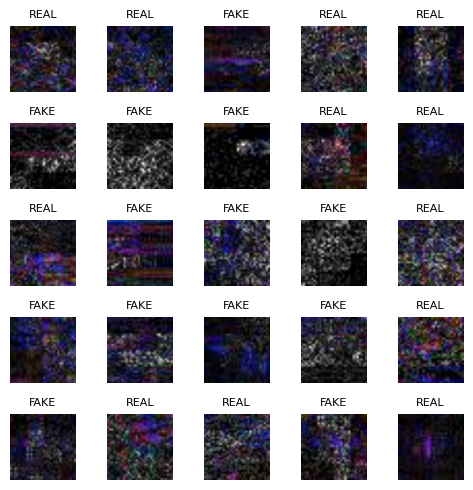

In [11]:
# display 5*5 images
train_features, train_labels = next(iter(ela_train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# display 5*5 images
plot_images(train_features, train_labels)


## Pretrained Model Transfer Learning

In [10]:
from model.ResNet import ResNetTransferLearning
from model.VGG16 import VGGTransferLearning
from model.EfficientNet import EfficientNetTransferLearning
from model.MobileNet import MobileNetTransferLearning
from model.ViT import ViTTransferLearning
from model.CNNSelfImplement import CNNModel

### ResNet

In [11]:

ResNet_model = ResNetTransferLearning(img_height=224, img_width=224)
# print(ResNet_model)
summary(ResNet_model, (1, 3, img_height, img_width))

Layer (type:depth-idx)                        Output Shape              Param #
ResNetTransferLearning                        [1, 1]                    --
├─ResNet: 1-1                                 [1, 2048]                 --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         128
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 256, 56, 56]          --
│    │    └─Bottleneck: 3-1                   [1, 256, 56, 56]          75,008
│    │    └─Bottleneck: 3-2                   [1, 256, 56, 56]          70,400
│    │    └─Bottleneck: 3-3                   [1, 256, 56, 56]          70,400
│    └─Sequential: 2-6                        [1, 512, 28, 28]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 28, 28]          379,392

In [ ]:
optimizer_res = torch.optim.Adam(ResNet_model.parameters(), lr=0.001, weight_decay = 0.005)
train_losses_res, val_accuracies_res, train_accuracies_res = train_loop(ResNet_model, optimizer_res, train_loader, val_loader, device, epochs=10)

# Training and Validation Time: 27m 56.2s

# Save the model weights
ResNet_model.save_model("./model_weight/ResNet_model.pth")
# Save the metrics
save_metrics("ResNet", train_losses_res, val_accuracies_res, train_accuracies_res)

In [ ]:

ResNet_model2 = ResNetTransferLearning(img_height=224, img_width=224)
optimizer_res2 = torch.optim.SGD(ResNet_model2.parameters(), lr=0.001, weight_decay = 0.005, momentum=0.9)
train_losses_res2, val_accuracies_res2, train_accuracies_res2 = train_loop(ResNet_model2, optimizer_res2, train_loader, val_loader, device, epochs=10)

# Training and Validation Time: 27m 25.6s

# Save the model weights
ResNet_model2.save_model("./model_weight/ResNet_model2.pth")
# Save the metrics
save_metrics("ResNet2", train_losses_res2, val_accuracies_res2, train_accuracies_res2)

### VGG16

In [12]:

# Create an instance of the model
VGG_model = VGGTransferLearning(img_height=224, img_width=224)

# print(VGG_model)
summary(VGG_model, (1, 3, img_height, img_width))


Layer (type:depth-idx)                   Output Shape              Param #
VGGTransferLearning                      [1, 1]                    --
├─VGG: 1-1                               [1, 512]                  --
│    └─Sequential: 2-1                   [1, 512, 7, 7]            --
│    │    └─Conv2d: 3-1                  [1, 64, 224, 224]         1,792
│    │    └─ReLU: 3-2                    [1, 64, 224, 224]         --
│    │    └─Conv2d: 3-3                  [1, 64, 224, 224]         36,928
│    │    └─ReLU: 3-4                    [1, 64, 224, 224]         --
│    │    └─MaxPool2d: 3-5               [1, 64, 112, 112]         --
│    │    └─Conv2d: 3-6                  [1, 128, 112, 112]        73,856
│    │    └─ReLU: 3-7                    [1, 128, 112, 112]        --
│    │    └─Conv2d: 3-8                  [1, 128, 112, 112]        147,584
│    │    └─ReLU: 3-9                    [1, 128, 112, 112]        --
│    │    └─MaxPool2d: 3-10              [1, 128, 56, 56]          --

In [ ]:

optimizer_vgg = torch.optim.Adam(VGG_model.parameters(), lr=0.001, weight_decay = 0.005)
train_losses_vgg, val_accuracies_vgg, train_accuracies_vgg = train_loop(VGG_model, optimizer_vgg, train_loader, val_loader, device, epochs=10)

# Training and Validation Time: 41m 49.4s

# Save the model weights
VGG_model.save_model("./model_weight/VGG_model.pth")
# Save the metrics
save_metrics("VGG", train_losses_vgg, val_accuracies_vgg, train_accuracies_vgg)

In [ ]:

# Create an instance of the model
VGG_model2 = VGGTransferLearning(img_height=224, img_width=224)

optimizer_vgg2 = torch.optim.SGD(VGG_model2.parameters(), lr=0.001, weight_decay = 0.005, momentum=0.9)
train_losses_vgg2, val_accuracies_vgg2, train_accuracies_vgg2 = train_loop(VGG_model2, optimizer_vgg2, train_loader, val_loader, device, epochs=10)

# Training and Validation Time: 42m 13.0s

# Save the model weights
VGG_model2.save_model("./model_weight/VGG_model2.pth")
# Save the metrics
save_metrics("VGG2", train_losses_vgg2, val_accuracies_vgg2, train_accuracies_vgg2)

### EfficientNet

In [13]:

# Create an instance of the model
Eff_model = EfficientNetTransferLearning(img_height, img_width)
# print(Eff_model)

summary(Eff_model, (1, 3, img_height, img_width))


Layer (type:depth-idx)                                       Output Shape              Param #
EfficientNetTransferLearning                                 [1, 1]                    --
├─EfficientNet: 1-1                                          [1, 512]                  --
│    └─Sequential: 2-1                                       [1, 1280, 7, 7]           --
│    │    └─Conv2dNormActivation: 3-1                        [1, 24, 112, 112]         696
│    │    └─Sequential: 3-2                                  [1, 24, 112, 112]         10,464
│    │    └─Sequential: 3-3                                  [1, 48, 56, 56]           303,552
│    │    └─Sequential: 3-4                                  [1, 64, 28, 28]           589,184
│    │    └─Sequential: 3-5                                  [1, 128, 14, 14]          917,680
│    │    └─Sequential: 3-6                                  [1, 160, 14, 14]          3,463,840
│    │    └─Sequential: 3-7                                  [1, 256

In [ ]:

optimizer_eff = torch.optim.Adam(Eff_model.parameters(), lr=0.001, weight_decay = 0.005)

train_losses_eff, val_accuracies_eff, train_accuracies_eff = train_loop(Eff_model, optimizer_eff, train_loader, val_loader, device, epochs=10)

# Training and Validation Time: 30m 37.0s

# Save the model weights
Eff_model.save_model("./model_weight/Eff_model.pth")
# Save the metrics
save_metrics("Eff", train_losses_eff, val_accuracies_eff, train_accuracies_eff)

In [ ]:

# Create an instance of the model
Eff_model2 = EfficientNetTransferLearning(img_height, img_width)

optimizer_eff2 = torch.optim.SGD(Eff_model2.parameters(), lr=0.001, weight_decay = 0.005, momentum=0.9)
train_losses_eff2, val_accuracies_eff2, train_accuracies_eff2 = train_loop(Eff_model2, optimizer_eff2, train_loader, val_loader, device, epochs=10)

# Training and Validation Time: 30m 14.6s

# Save the model weights
Eff_model2.save_model("./model_weight/Eff_model2.pth")

# Save the metrics
save_metrics("Eff2", train_losses_eff2, val_accuracies_eff2, train_accuracies_eff2)

### MobileNet

In [14]:

# Create an instance of the model
Mobile_model = MobileNetTransferLearning(img_height, img_width)

# print(Mobile_model)
summary(Mobile_model, (1, 3, img_height, img_width))

Layer (type:depth-idx)                                  Output Shape              Param #
MobileNetTransferLearning                               [1, 1]                    --
├─MobileNetV3: 1-1                                      [1, 576]                  --
│    └─Sequential: 2-1                                  [1, 576, 7, 7]            --
│    │    └─Conv2dNormActivation: 3-1                   [1, 16, 112, 112]         464
│    │    └─InvertedResidual: 3-2                       [1, 16, 56, 56]           744
│    │    └─InvertedResidual: 3-3                       [1, 24, 28, 28]           3,864
│    │    └─InvertedResidual: 3-4                       [1, 24, 28, 28]           5,416
│    │    └─InvertedResidual: 3-5                       [1, 40, 14, 14]           13,736
│    │    └─InvertedResidual: 3-6                       [1, 40, 14, 14]           57,264
│    │    └─InvertedResidual: 3-7                       [1, 40, 14, 14]           57,264
│    │    └─InvertedResidual: 3-8       

In [ ]:

optimizer_mobile = torch.optim.Adam(Mobile_model.parameters(), lr=0.001, weight_decay = 0.005)

train_losses_mobile, val_accuracies_mobile, train_accuracies_mobile = train_loop(Mobile_model, optimizer_mobile, train_loader, val_loader, device, epochs=10)

# Training and Validation Time: 10m 40.5s

# Save the model weights
Mobile_model.save_model("./model_weight/MobileNet_model.pth")
# Save the metrics
save_metrics("MobileNet", train_losses_mobile, val_accuracies_mobile, train_accuracies_mobile)

In [ ]:
# Create an instance of the model
Mobile_model2 = MobileNetTransferLearning(img_height, img_width)

optimizer_mobile2 = torch.optim.SGD(Mobile_model2.parameters(), lr=0.001, weight_decay = 0.005, momentum=0.9)
train_losses_mobile2, val_accuracies_mobile2, train_accuracies_mobile2 =  train_loop(Mobile_model2, optimizer_mobile2, train_loader, val_loader, device, epochs=10)

# Training and Validation Time: 10m 44.8s

# Save the model weights
Mobile_model2.save_model("./model_weight/MobileNet_model2.pth")
# Save the metrics
save_metrics("MobileNet2", train_losses_mobile2, val_accuracies_mobile2, train_accuracies_mobile2)

### Vision Transformer (ViT)

In [15]:
ViT_model = ViTTransferLearning(img_height, img_width)

# print(ViT_model)
summary(ViT_model, (1, 3, img_height, img_width))

Layer (type:depth-idx)                             Output Shape              Param #
ViTTransferLearning                                [1, 1]                    --
├─VisionTransformer: 1-1                           [1, 768]                  768
│    └─Conv2d: 2-1                                 [1, 768, 14, 14]          590,592
│    └─Encoder: 2-2                                [1, 197, 768]             151,296
│    │    └─Dropout: 3-1                           [1, 197, 768]             --
│    │    └─Sequential: 3-2                        [1, 197, 768]             85,054,464
│    │    └─LayerNorm: 3-3                         [1, 197, 768]             1,536
│    └─Sequential: 2-3                             [1, 768]                  --
│    │    └─Linear: 3-4                            [1, 768]                  590,592
├─BatchNorm1d: 1-2                                 [1, 768]                  1,536
├─Linear: 1-3                                      [1, 256]                  196,864


In [ ]:

optimizer_vit = torch.optim.Adam(ViT_model.parameters(), lr=0.001, weight_decay = 0.005)
train_losses_vit, val_accuracies_vit, train_accuracies_vit =  train_loop(ViT_model, optimizer_vit, train_loader, val_loader, device, epochs=10)

# Training and Validation Time: 58m 34.1s

# Save the model weights
ViT_model.save_model("./model_weight/ViT_model.pth")
# Save the metrics
save_metrics("ViT", train_losses_vit, val_accuracies_vit, train_accuracies_vit)

In [ ]:
ViT_model2 = ViTTransferLearning(img_height, img_width)

optimizer_vit2 = torch.optim.SGD(ViT_model2.parameters(), lr=0.001, weight_decay = 0.005, momentum=0.9)
train_losses_vit2, val_accuracies_vit2, train_accuracies_vit2 = train_loop(ViT_model2, optimizer_vit2, train_loader, val_loader, device, epochs=10)

# Training and Validation Time: 78m 30.10

# Save the model weights
ViT_model2.save_model("./model_weight/ViT_model2.pth")

# Save the metrics
save_metrics("ViT2", train_losses_vit2, val_accuracies_vit2, train_accuracies_vit2)

### CNN

In [16]:

# Create an instance of the model
CNN_model = CNNModel(img_height=224, img_width=224)
# print(model)
summary(CNN_model, (1, 3, img_height, img_width))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [1, 1]                    --
├─Conv2d: 1-1                            [1, 16, 222, 222]         448
├─MaxPool2d: 1-2                         [1, 16, 111, 111]         --
├─Conv2d: 1-3                            [1, 32, 109, 109]         4,640
├─MaxPool2d: 1-4                         [1, 32, 54, 54]           --
├─Conv2d: 1-5                            [1, 16, 52, 52]           4,624
├─MaxPool2d: 1-6                         [1, 16, 26, 26]           --
├─Conv2d: 1-7                            [1, 16, 24, 24]           2,320
├─MaxPool2d: 1-8                         [1, 16, 12, 12]           --
├─Flatten: 1-9                           [1, 2304]                 --
├─Linear: 1-10                           [1, 256]                  590,080
├─Dropout: 1-11                          [1, 256]                  --
├─Linear: 1-12                           [1, 64]                   16,

In [ ]:

optimizer_cnn = torch.optim.Adam(CNN_model.parameters(), lr=0.001, weight_decay = 0.005)
train_losses_cnn, val_accuracies_cnn, train_accuracies_cnn = train_loop(CNN_model, optimizer_cnn, train_loader, val_loader, device, epochs=10)

# Training and Validation Time: 11m 51.3s

# Save the model weights
CNN_model.save_model("./model_weight/CNN_model.pth")
# Save the metrics
save_metrics("CNN", train_losses_cnn, val_accuracies_cnn, train_accuracies_cnn)

In [ ]:
CNN_model2 = CNNModel(img_height=224, img_width=224)

optimizer_cnn2 = torch.optim.SGD(CNN_model2.parameters(), lr=0.001, weight_decay = 0.005, momentum=0.9)
train_losses_cnn2, val_accuracies_cnn2, train_accuracies_cnn2 = train_loop(CNN_model2, optimizer_cnn2, train_loader, val_loader, device, epochs=10)

# Training and Validation Time: 11m 8.8s

# Save the model weights
CNN_model2.save_model("./model_weight/CNN_model2.pth")
# Save the metrics
save_metrics("CNN2", train_losses_cnn2, val_accuracies_cnn2, train_accuracies_cnn2)

## ELA+CNN hyperparameter tunning

In [ ]:
from model.CNNSelfImplement import CNNModel

CNN_model_ela_tunning = CNNModel(img_height=224, img_width=224)
tuning_results = hyperparameter_tuning(CNN_model_ela_tunning, ela_train_loader, ela_val_loader, device, epochs=3)

save_tuning_results(tuning_results, './training_result/hyperparameter_tuning_results.csv')

In [ ]:

# show tunning result
tuning_results = pd.read_csv('./training_result/hyperparameter_tuning_results.csv')
print(tuning_results)

  optimizer  learning_rate  weight_decay  best_val_accuracy  \
0      Adam          0.010        0.0050               50.0   
1       SGD          0.010        0.0050               50.0   
2      Adam          0.010        0.0005               50.0   
3       SGD          0.010        0.0005               50.0   
4      Adam          0.001        0.0050               50.0   
5       SGD          0.001        0.0050               50.0   
6      Adam          0.001        0.0005               50.0   
7       SGD          0.001        0.0005               50.0   

   best_train_accuracy  average_train_accuracy  average_val_accuracy  
0            50.781250               49.537182                  50.0  
1            53.710938               50.021952                  50.0  
2            52.343750               49.707854                  50.0  
3            60.937500               49.914269                  50.0  
4            52.343750               49.662664                  50.0  
5     

## ELA (Error Level Analysis) + CNN

### Training Preparation

In [17]:
from model.CNNSelfImplement import CNNModel
# from model.CNN import CNNModelll

### CNN

In [18]:

# Create an instance of the model
CNN_model_ela = CNNModel(img_height=224, img_width=224)
# print(model)
summary(CNN_model_ela, (1, 3, img_height, img_width))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [1, 1]                    --
├─Conv2d: 1-1                            [1, 16, 222, 222]         448
├─MaxPool2d: 1-2                         [1, 16, 111, 111]         --
├─Conv2d: 1-3                            [1, 32, 109, 109]         4,640
├─MaxPool2d: 1-4                         [1, 32, 54, 54]           --
├─Conv2d: 1-5                            [1, 16, 52, 52]           4,624
├─MaxPool2d: 1-6                         [1, 16, 26, 26]           --
├─Conv2d: 1-7                            [1, 16, 24, 24]           2,320
├─MaxPool2d: 1-8                         [1, 16, 12, 12]           --
├─Flatten: 1-9                           [1, 2304]                 --
├─Linear: 1-10                           [1, 256]                  590,080
├─Dropout: 1-11                          [1, 256]                  --
├─Linear: 1-12                           [1, 64]                   16,

In [ ]:
optimizer_cnn_ela = torch.optim.Adam(CNN_model_ela.parameters(), lr=0.001, weight_decay = 0.005)
train_losses_cnn_ela, val_accuracies_cnn_ela, train_accuracies_cnn_ela = train_loop(CNN_model_ela, optimizer_cnn_ela, ela_train_loader, ela_val_loader, device, epochs=10)

# Training and Validation Time: 11m 30.8s

# Save the model weights
CNN_model_ela.save_model("./model_weight/CNN_model_ela.pth")
# Save the metrics
save_metrics("CNN_ELA", train_losses_cnn_ela, val_accuracies_cnn_ela, train_accuracies_cnn_ela)

In [ ]:
CNN_model_ela2 = CNNModel(img_height=224, img_width=224)

optimizer_cnn_ela2 = torch.optim.SGD(CNN_model_ela2.parameters(), lr=0.001, weight_decay = 0.005, momentum=0.9)
train_losses_cnn_ela2, val_accuracies_cnn_ela2, train_accuracies_cnn_ela2 = train_loop(CNN_model_ela2, optimizer_cnn_ela2, ela_train_loader, ela_val_loader, device, epochs=10)

# Training and Validation Time: 11m 14.6s

# Save the model weights
CNN_model_ela2.save_model("./model_weight/CNN_model_ela2.pth")
# Save the metrics
save_metrics("CNN_ELA2", train_losses_cnn_ela2, val_accuracies_cnn_ela2, train_accuracies_cnn_ela2)

### MobileNet

In [ ]:
Mobile_model_ela = MobileNetTransferLearning(img_height, img_width)

optimizer_mobile_ela = torch.optim.Adam(Mobile_model_ela.parameters(), lr=0.001, weight_decay = 0.005)
train_losses_mobile_ela, val_accuracies_mobile_ela, train_accuracies_mobile_ela = train_loop(Mobile_model_ela, optimizer_mobile_ela, ela_train_loader, ela_val_loader, device, epochs=10)

# Training and Validation Time: 12m 7.6s

# Save the model weights
Mobile_model_ela.save_model("./model_weight/MobileNet_model_ela.pth")
# Save the metrics
save_metrics("MobileNet_ELA", train_losses_mobile_ela, val_accuracies_mobile_ela, train_accuracies_mobile_ela)

In [ ]:
# Create an instance of the model
Mobile_model_ela2 = MobileNetTransferLearning(img_height, img_width)

optimizer_mobile_ela2 = torch.optim.SGD(Mobile_model_ela2.parameters(), lr=0.001, weight_decay = 0.005, momentum=0.9)
train_losses_mobile_ela2, val_accuracies_mobile_ela2, train_accuracies_mobile_ela2 = train_loop(Mobile_model_ela2, optimizer_mobile_ela2, ela_train_loader, ela_val_loader, device, epochs=10)

# Training and Validation Time: 11m 31.6s

# Save the model weights
Mobile_model_ela2.save_model("./model_weight/MobileNet_model_ela2.pth")
# Save the metrics
save_metrics("MobileNet_ELA2", train_losses_mobile_ela2, val_accuracies_mobile_ela2, train_accuracies_mobile_ela2)

### EfficientNet

In [ ]:
Eff_model_ela = EfficientNetTransferLearning(img_height, img_width)

optimizer_eff_ela = torch.optim.Adam(Eff_model_ela.parameters(), lr=0.001, weight_decay = 0.005)
train_losses_eff_ela, val_accuracies_eff_ela, train_accuracies_eff_ela = train_loop(Eff_model_ela, optimizer_eff_ela, ela_train_loader, ela_val_loader, device, epochs=10)

# Training and Validation Time: 35m 26.3s

# Save the model weights
Eff_model_ela.save_model("./model_weight/EfficientNet_model_ela.pth")
# Save the metrics
save_metrics("EfficientNet_ELA", train_losses_eff_ela, val_accuracies_eff_ela, train_accuracies_eff_ela)

In [ ]:

Eff_model_ela2 = EfficientNetTransferLearning(img_height, img_width)

optimizer_eff_ela2 = torch.optim.SGD(Eff_model_ela2.parameters(), lr=0.001, weight_decay = 0.005, momentum=0.9)
train_losses_eff_ela2, val_accuracies_eff_ela2, train_accuracies_eff_ela2 = train_loop(Eff_model_ela2, optimizer_eff_ela2, ela_train_loader, ela_val_loader, device, epochs=10)

# Training and Validation Time: 31m 40.7s

# Save the model weights
Eff_model_ela2.save_model("./model_weight/EfficientNet_model_ela2.pth")
# Save the metrics
save_metrics("EfficientNet_ELA2", train_losses_eff_ela2, val_accuracies_eff_ela2, train_accuracies_eff_ela2)

## Evaluation on Training

### Training and Validation Time


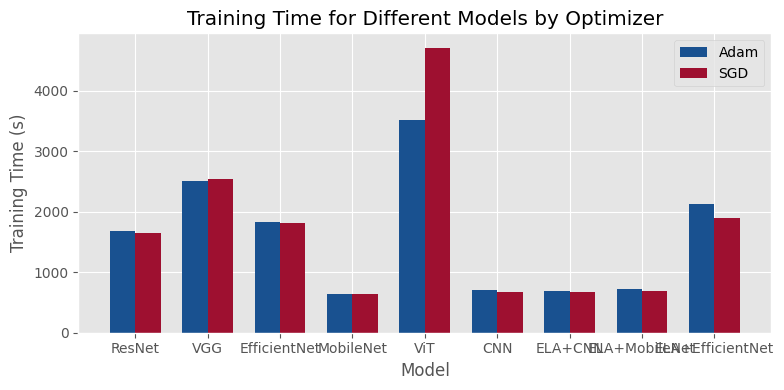

In [3]:
save_training_times_to_csv('./training_result/training_times.csv')

plot_training_time('./training_result/training_times.csv')

### Training and Validation Loss

In [5]:
# Define models and optimizers
model_names = ['ResNet', 'VGG', 'EfficientNet', 'MobileNet', 'ViT', 'CNN', 'CNN_ELA', 'MobileNet_ELA', 'EfficientNet_ELA']
optimizer_names = ['Adam', 'SGD']
model_colors = {
    'ResNet': '#666dcb', #'blue',
    'VGG': '#ffb92a', #'green',
    'EfficientNet': '#ed5314', #'orange',
    'MobileNet': "#9bca3e", # 'red',
    'ViT': '#feeb51', #'purple',
    'CNN': '#3abbc9', #'black',
    'CNN_ELA': '#8bd6e1', #'brown',
    'MobileNet_ELA': '#b2df8a', #'gray',
    'EfficientNet_ELA': '#ff8a82', #'pink'
}


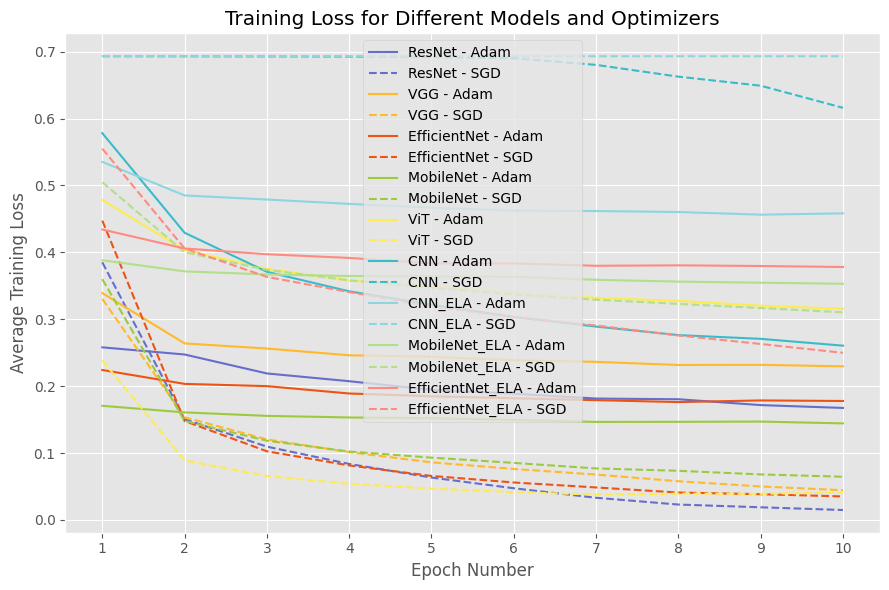

In [6]:

# File paths for each model and optimizer
file_paths_train_loss = {
    'ResNet_Adam': './training_result/ResNet_TrainLoss.csv',
    'ResNet_SGD': './training_result/ResNet2_TrainLoss.csv',
    'VGG_Adam': './training_result/VGG_TrainLoss.csv',
    'VGG_SGD': './training_result/VGG2_TrainLoss.csv',
    'EfficientNet_Adam': './training_result/Eff_TrainLoss.csv',
    'EfficientNet_SGD': './training_result/Eff2_TrainLoss.csv',
    'MobileNet_Adam': './training_result/MobileNet_TrainLoss.csv',
    'MobileNet_SGD': './training_result/MobileNet2_TrainLoss.csv',
    'ViT_Adam': './training_result/ViT_TrainLoss.csv',
    'ViT_SGD': './training_result/ViT2_TrainLoss.csv',
    'CNN_Adam': './training_result/CNN_TrainLoss.csv',
    'CNN_SGD': './training_result/CNN2_TrainLoss.csv',
    'CNN_ELA_Adam': './training_result/CNN_ELA_TrainLoss.csv',
    'CNN_ELA_SGD': './training_result/CNN_ELA2_TrainLoss.csv',
    'MobileNet_ELA_Adam': './training_result/MobileNet_ELA_TrainLoss.csv',
    'MobileNet_ELA_SGD': './training_result/MobileNet_ELA2_TrainLoss.csv',
    'EfficientNet_ELA_Adam': './training_result/EfficientNet_ELA_TrainLoss.csv',
    'EfficientNet_ELA_SGD': './training_result/EfficientNet_ELA2_TrainLoss.csv'
}

# Load loss data
loss_data = {}
for key, path in file_paths_train_loss.items():
    loss_data[key] = load_train_data(path)


# Plot training loss
plot_result(loss_data, model_names, optimizer_names, model_colors, 'Training Loss for Different Models and Optimizers', 'Average Training Loss')

### Training and Validation Accuracy

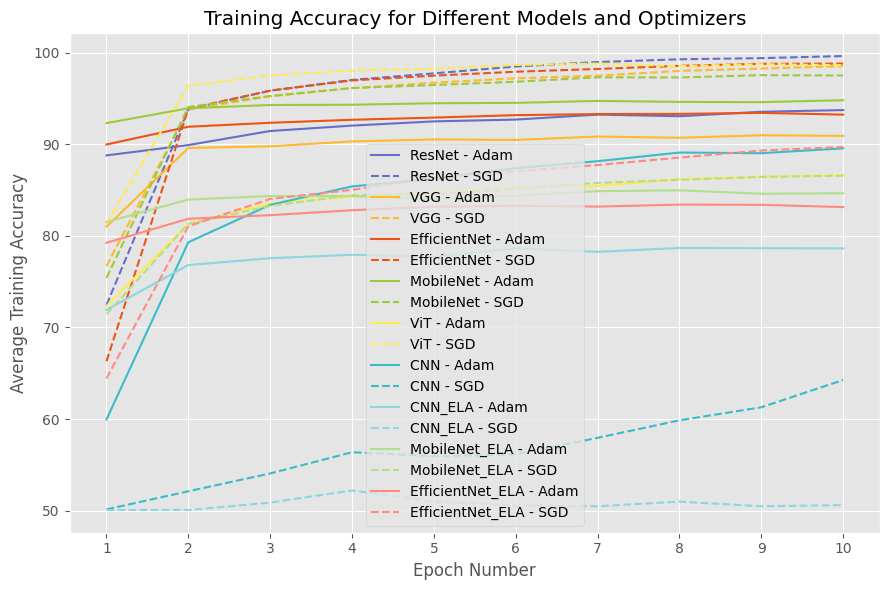

In [7]:

# File paths for each model and optimizer
file_paths_train_acc = {
    'ResNet_Adam': './training_result/ResNet_TrainAcc.csv',
    'ResNet_SGD': './training_result/ResNet2_TrainAcc.csv',
    'VGG_Adam': './training_result/VGG_TrainAcc.csv',
    'VGG_SGD': './training_result/VGG2_TrainAcc.csv',
    'EfficientNet_Adam': './training_result/Eff_TrainAcc.csv',
    'EfficientNet_SGD': './training_result/Eff2_TrainAcc.csv',
    'MobileNet_Adam': './training_result/MobileNet_TrainAcc.csv',
    'MobileNet_SGD': './training_result/MobileNet2_TrainAcc.csv',
    'ViT_Adam': './training_result/ViT_TrainAcc.csv',
    'ViT_SGD': './training_result/ViT2_TrainAcc.csv',
    'CNN_Adam': './training_result/CNN_TrainAcc.csv',
    'CNN_SGD': './training_result/CNN2_TrainAcc.csv',
    'CNN_ELA_Adam': './training_result/CNN_ELA_TrainAcc.csv',
    'CNN_ELA_SGD': './training_result/CNN_ELA2_TrainAcc.csv',
    'MobileNet_ELA_Adam': './training_result/MobileNet_ELA_TrainAcc.csv',
    'MobileNet_ELA_SGD': './training_result/MobileNet_ELA2_TrainAcc.csv',
    'EfficientNet_ELA_Adam': './training_result/EfficientNet_ELA_TrainAcc.csv',
    'EfficientNet_ELA_SGD': './training_result/EfficientNet_ELA2_TrainAcc.csv'
}

# Load loss data
train_acc_data = {}
for key, path in file_paths_train_acc.items():
    train_acc_data[key] = load_train_data(path)

# Plot training loss
plot_result(train_acc_data, model_names, optimizer_names, model_colors, 'Training Accuracy for Different Models and Optimizers', 'Average Training Accuracy')

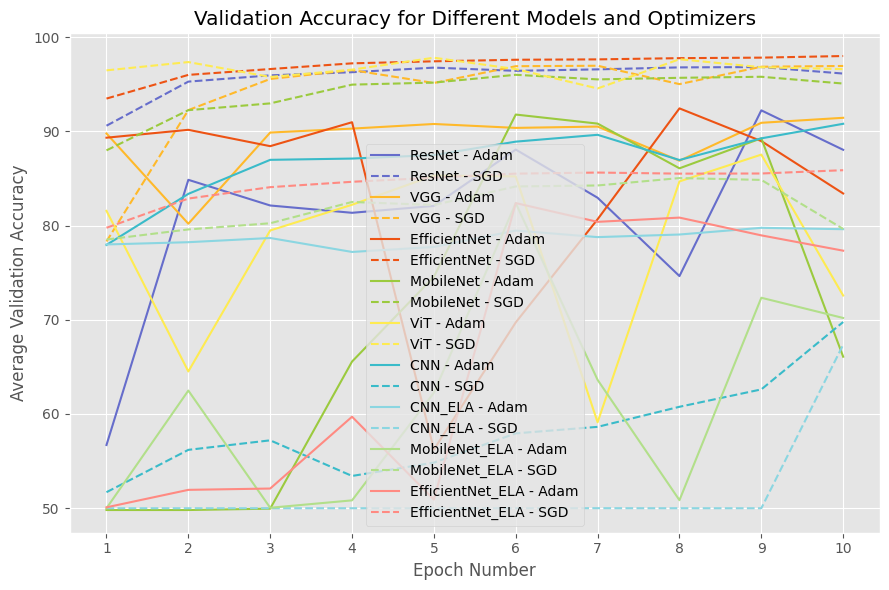

In [8]:

# File paths for each model and optimizer
file_paths_val_acc = {
    'ResNet_Adam': './training_result/ResNet_ValAcc.csv',
    'ResNet_SGD': './training_result/ResNet2_ValAcc.csv',
    'VGG_Adam': './training_result/VGG_ValAcc.csv',
    'VGG_SGD': './training_result/VGG2_ValAcc.csv',
    'EfficientNet_Adam': './training_result/Eff_ValAcc.csv',
    'EfficientNet_SGD': './training_result/Eff2_ValAcc.csv',
    'MobileNet_Adam': './training_result/MobileNet_ValAcc.csv',
    'MobileNet_SGD': './training_result/MobileNet2_ValAcc.csv',
    'ViT_Adam': './training_result/ViT_ValAcc.csv',
    'ViT_SGD': './training_result/ViT2_ValAcc.csv',
    'CNN_Adam': './training_result/CNN_ValAcc.csv',
    'CNN_SGD': './training_result/CNN2_ValAcc.csv',
    'CNN_ELA_Adam': './training_result/CNN_ELA_ValAcc.csv',
    'CNN_ELA_SGD': './training_result/CNN_ELA2_ValAcc.csv',
    'MobileNet_ELA_Adam': './training_result/MobileNet_ELA_ValAcc.csv',
    'MobileNet_ELA_SGD': './training_result/MobileNet_ELA2_ValAcc.csv',
    'EfficientNet_ELA_Adam': './training_result/EfficientNet_ELA_ValAcc.csv',
    'EfficientNet_ELA_SGD': './training_result/EfficientNet_ELA2_ValAcc.csv'
}

# Load loss data
val_acc_data = {}
for key, path in file_paths_val_acc.items():
    val_acc_data[key] = load_val_data(path)


# Plot training loss
plot_result(val_acc_data, model_names, optimizer_names, model_colors, 'Validation Accuracy for Different Models and Optimizers', 'Average Validation Accuracy')

## Testing

using test set to evaluate the model and get the final accuracy, precision, recall, and F1-score.

In [ ]:

# ResNet_Adam_path = './model_weight/ResNet_model.pth'
ResNet_SGD_path = './model_weight/ResNet_model2.pth'
# VGG_Adam_path = './model_weight/VGG_model.pth'
VGG_SGD_path = './model_weight/VGG_model2.pth'
# Eff_Adam_path = './model_weight/Eff_model.pth'
Eff_SGD_path = './model_weight/Eff_model2.pth'
# Mobile_Adam_path = './model_weight/MobileNet_model.pth'
Mobile_SGD_path = './model_weight/MobileNet_model2.pth'
# ViT_Adam_path = './model_weight/VisionTransformer_model.pth'
ViT_SGD_path = './model_weight/VisionTransformer_model2.pth'
CNN_Adam_path = './model_weight/CNN_model.pth'
# CNN_SGD_path = './model_weight/CNN_model2.pth'
CNN_ELA_Adam_path = './model_weight/CNN_model_ela.pth'
# CNN_ELA_SGD_path = './model_weight/CNN_model_ela2.pth'
# MobileNet_ELA_Adam_path = './model_weight/MobileNet_model_ela.pth'
MobileNet_ELA_SGD_path = './model_weight/MobileNet_model_ela2.pth'
# Eff_Adam_path = './model_weight/EfficientNet_model_ela.pth'
EfficientNet_ELA_SGD_path = './model_weight/EfficientNet_model_ela2.pth'


# ResNet_Adam_model = load_model(ResNetTransferLearning, ResNet_Adam_path, device)
ResNet_SGD_model = load_model(ResNetTransferLearning, ResNet_SGD_path, device)
# VGG_Adam_model = load_model(VGGTransferLearning(img_height, img_width), VGG_Adam_path, device)
VGG_SGD_model = load_model(VGGTransferLearning, VGG_SGD_path, device)
# Eff_Adam_model = load_model(EfficientNetTransferLearning, Eff_Adam_path, device)
Eff_SGD_model = load_model(EfficientNetTransferLearning, Eff_SGD_path, device)
# Mobile_Adam_model = load_model(MobileNetTransferLearning, Mobile_Adam_path, device)
Mobile_SGD_model = load_model(MobileNetTransferLearning, Mobile_SGD_path, device)
# ViT_Adam_model = load_model(ViTTransferLearning(img_height, img_width), ViT_Adam_path, device)
ViT_SGD_model = load_model(ViTTransferLearning, ViT_SGD_path, device)
CNN_Adam_model = load_model(CNNModel, CNN_Adam_path, device)
# CNN_SGD_model = load_model(CNNModel, CNN_SGD_path, device)
CNN_ELA_Adam_model = load_model(CNNModel, CNN_ELA_Adam_path, device)
# CNN_ELA_SGD_model = load_model(CNNModel, CNN_ELA_SGD_path, device)
# MobileNet_ELA_Adam_model = load_model(MobileNetTransferLearning, MobileNet_ELA_Adam_path, device)
MobileNet_ELA_SGD_model = load_model(MobileNetTransferLearning, MobileNet_ELA_SGD_path, device),
# Eff_Adam_model = load_model(EfficientNetTransferLearning, Eff_Adam_path, device)
EfficientNet_ELA_SGD_model = load_model(EfficientNetTransferLearning, EfficientNet_ELA_SGD_path, device)


In [ ]:
y_true_resnet, y_pred_resnet = test_model(ResNet_SGD_model, device, test_loader)
y_true_vgg, y_pred_vgg = test_model(VGG_SGD_model, device, test_loader)
y_true_eff, y_pred_eff = test_model(Eff_SGD_model, device, test_loader)
y_true_mobile, y_pred_mobile = test_model(Mobile_SGD_model, device, test_loader)
y_true_vit, y_pred_vit = test_model(ViT_SGD_model, device, test_loader)
y_true_cnn, y_pred_cnn = test_model(CNN_Adam_model, device, test_loader)
y_true_cnn_ela, y_pred_cnn_ela = test_model(CNN_ELA_Adam_model, device, ela_test_loader)
y_true_mobilenet_ela, y_pred_mobilenet_ela = test_model(MobileNet_ELA_SGD_model, device, ela_test_loader)
y_true_eff_ela, y_pred_eff_ela = test_model(EfficientNet_ELA_SGD_model, device, ela_test_loader)


In [ ]:

save_result_to_csv(y_true_resnet, y_pred_resnet, 'ResNet', './testing_result/ResNet_result.csv')
save_result_to_csv(y_true_vgg, y_pred_vgg, 'VGG', './testing_result/VGG_result.csv')
save_result_to_csv(y_true_eff, y_pred_eff, 'EfficientNet', './testing_result/EfficientNet_result.csv')
save_result_to_csv(y_true_mobile, y_pred_mobile, 'MobileNet', './testing_result/MobileNet_result.csv')
save_result_to_csv(y_true_vit, y_pred_vit, 'ViT', './testing_result/ViT_result.csv')
save_result_to_csv(y_true_cnn, y_pred_cnn, 'CNN', './testing_result/CNN_result.csv')
save_result_to_csv(y_true_cnn_ela, y_pred_cnn_ela, 'CNN_ELA', './testing_result/CNN_ELA_result.csv')
save_result_to_csv(y_true_mobilenet_ela, y_pred_mobilenet_ela, 'MobileNet_ELA', './testing_result/MobileNet_ELA_result.csv')
save_result_to_csv(y_true_eff_ela, y_pred_eff_ela, 'EfficientNet_ELA', './testing_result/EfficientNet_ELA_result.csv')


## Visualization

### Confusion Matrix

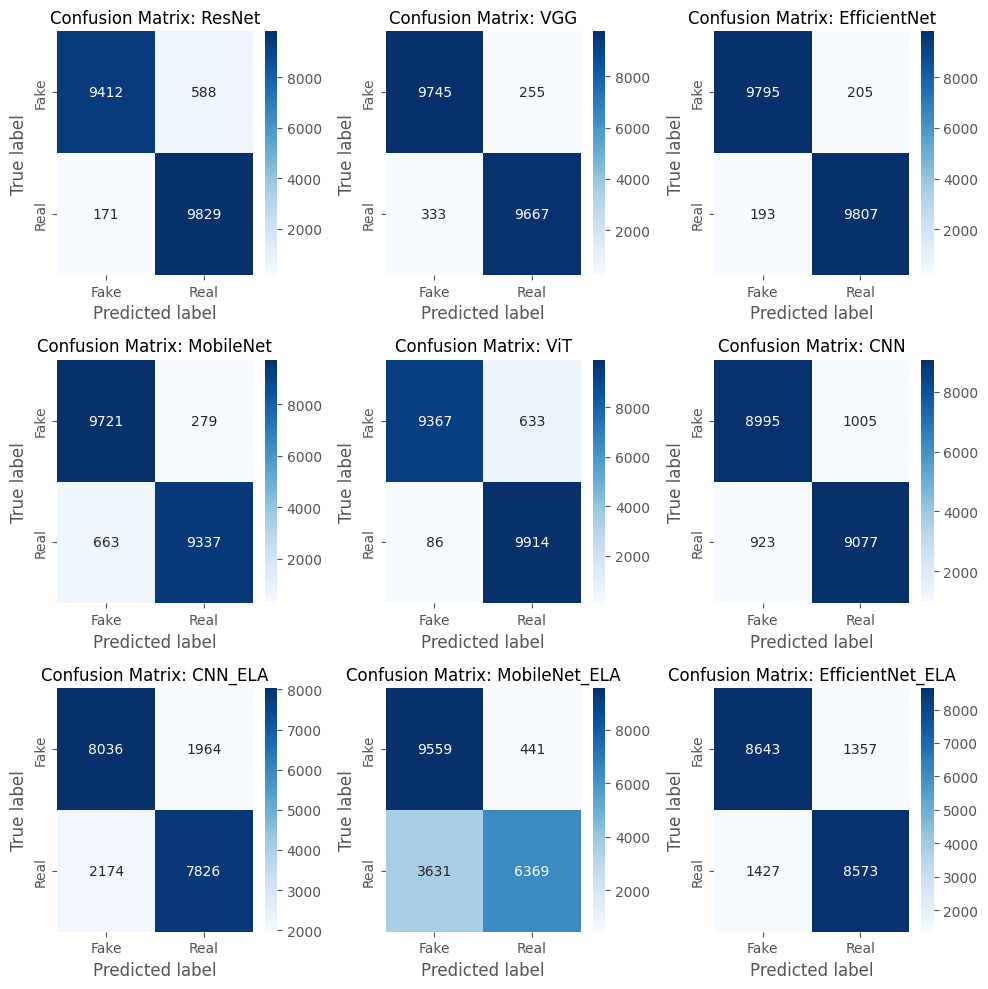

In [9]:

# Setup the figure and axes
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

model_names = ['ResNet', 'VGG', 'EfficientNet', 'MobileNet', 'ViT', 
               'CNN', 'CNN_ELA', 'MobileNet_ELA', 'EfficientNet_ELA']

for i in range(3):
    for j in range(3):
        if i * 3 + j < len(model_names):  # Ensure we don't exceed available models
            model_name = model_names[i * 3 + j]
            plot_confusion_matrix(axs[i, j], f"./testing_result/{model_name}_result.csv", ['Fake', 'Real'], model_name)

# Adjust layout
plt.tight_layout()
plt.show()


### Accuracy, Precision, Recall, and F1-Score

In [10]:
resnet_acc, resnet_precision, resnet_recall, resnet_f1 = calculate_metrics('./testing_result/ResNet_result.csv', 'ResNet')
vgg_acc, vgg_precision, vgg_recall, vgg_f1 = calculate_metrics('./testing_result/VGG_result.csv', 'VGG')
eff_acc, eff_precision, eff_recall, eff_f1 = calculate_metrics('./testing_result/EfficientNet_result.csv', 'EfficientNet')
mobile_acc, mobile_precision, mobile_recall, mobile_f1 = calculate_metrics('./testing_result/MobileNet_result.csv', 'MobileNet')
vit_acc, vit_precision, vit_recall, vit_f1 = calculate_metrics('./testing_result/ViT_result.csv', 'Vision Transformer')
cnn_acc, cnn_precision, cnn_recall, cnn_f1 = calculate_metrics('./testing_result/CNN_result.csv', 'CNN')
cnn_ela_acc, cnn_ela_precision, cnn_ela_recall, cnn_ela_f1 = calculate_metrics('./testing_result/CNN_ELA_result.csv', 'ELA+CNN')
mobilenet_ela_acc, mobilenet_ela_precision, mobilenet_ela_recall, mobilenet_ela_f1 = calculate_metrics('./testing_result/MobileNet_ELA_result.csv', 'ELA+MobileNet')
eff_ela_acc, eff_ela_precision, eff_ela_recall, eff_ela_f1 = calculate_metrics('./testing_result/EfficientNet_ELA_result.csv', 'ELA+EfficientNet')

# Create a DataFrame
metrics_df = pd.DataFrame({
    'Model': ['ResNet', 'VGG', 'EfficientNet', 'MobileNet', 'ViT', 'CNN', 'CNN_ELA', 'MobileNet_ELA', 'EfficientNet_ELA'],
    'Accuracy': [resnet_acc, vgg_acc, eff_acc, mobile_acc, vit_acc, cnn_acc, cnn_ela_acc, mobilenet_ela_acc, eff_ela_acc],
    'Precision': [resnet_precision, vgg_precision, eff_precision, mobile_precision, vit_precision, cnn_precision, cnn_ela_precision, mobilenet_ela_precision, eff_ela_precision],
    'Recall': [resnet_recall, vgg_recall, eff_recall, mobile_recall, vit_recall, cnn_recall, cnn_ela_recall, mobilenet_ela_recall, eff_ela_recall],
    'F1 Score': [resnet_f1, vgg_f1, eff_f1, mobile_f1, vit_f1, cnn_f1, cnn_ela_f1, mobilenet_ela_f1, eff_ela_f1]
})

# Display the DataFrame
print(metrics_df)



              Model  Accuracy  Precision  Recall  F1 Score
0            ResNet   0.96205   0.943554  0.9829  0.962825
1               VGG   0.97060   0.974300  0.9667  0.970485
2      EfficientNet   0.98010   0.979525  0.9807  0.980112
3         MobileNet   0.95290   0.970986  0.9337  0.951978
4               ViT   0.96405   0.939983  0.9914  0.965007
5               CNN   0.90360   0.900317  0.9077  0.903994
6           CNN_ELA   0.79310   0.799387  0.7826  0.790904
7     MobileNet_ELA   0.79640   0.935242  0.6369  0.757763
8  EfficientNet_ELA   0.86080   0.863343  0.8573  0.860311


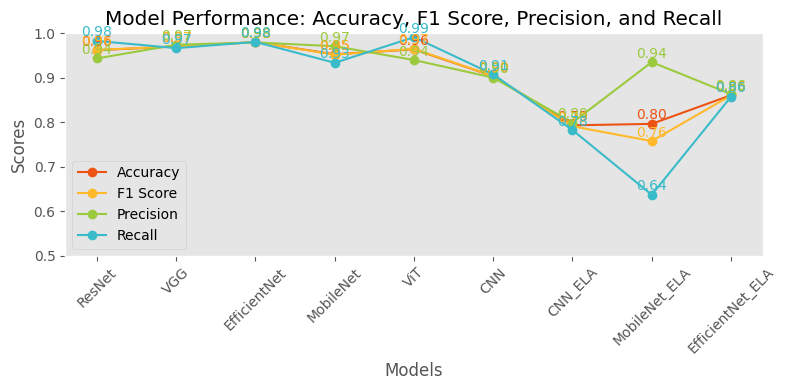

In [12]:
# Call the function to plot metrics
plot_model_metrics(metrics_df)